In [1]:

# Cell 1: Import libraries
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11


In [2]:
# Cell 2: Load conversion results
def load_language_conversion_results(results_file):
    """Load the language conversion results JSON file."""
    with open(results_file, 'r') as f:
        return json.load(f)

# Load data - UPDATE THIS PATH
results_file = "/data/jane/math_gender/conversion_test/language_conversion_results/language_conversion_results_20251215_122403.json"
data = load_language_conversion_results(results_file)
df = pd.DataFrame(data)

print(f"Loaded {len(df)} conversion results")
print(f"Models: {df['model'].unique().tolist()}")
print(f"Languages: {df['language'].unique().tolist()}")
print(f"Conversion types: {df['conversion_type'].unique().tolist()}")
print(f"Total ingredients: {df['ingredient'].nunique()}")


Loaded 888 conversion results
Models: ['gpt-4o', 'qwen-coder', 'llama-4', 'deepseek-r1']
Languages: ['english', 'hindi']
Conversion types: ['metric_to_us', 'us_to_metric']
Total ingredients: 215


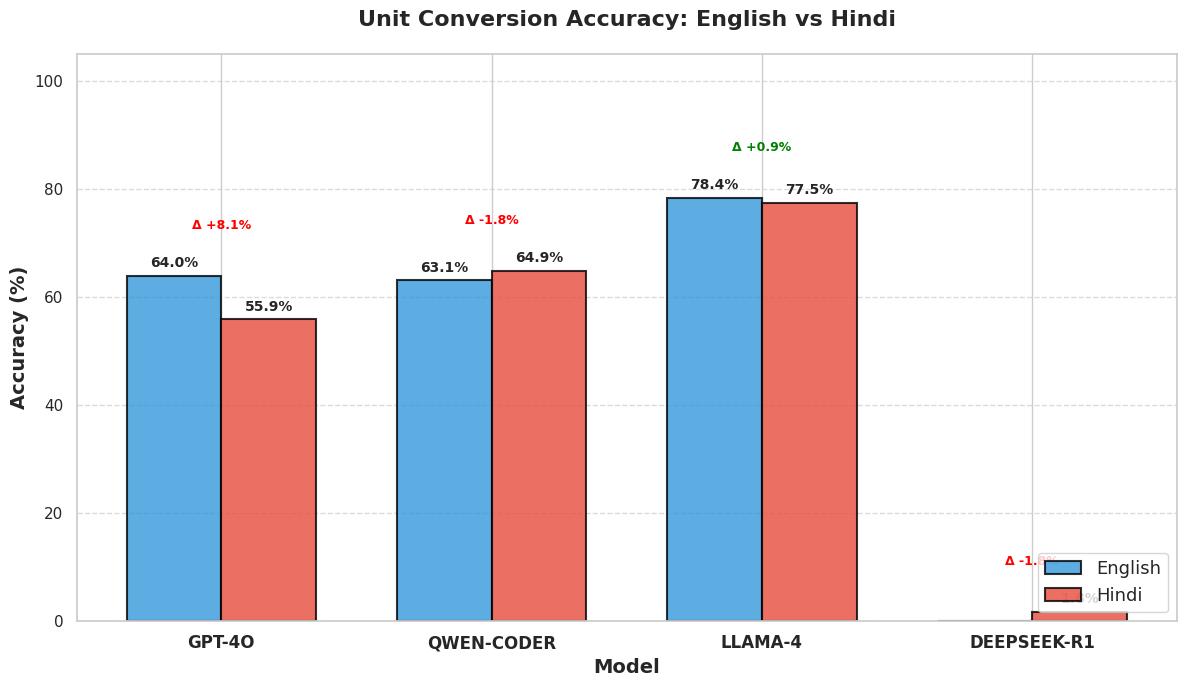

In [8]:

# Cell 3: Language comparison - Main result
def plot_language_comparison(df, output_dir="language_conversion_results/plots"):
    """Create side-by-side comparison of English vs Hindi accuracy."""
    
    # Calculate accuracy by model and language
    lang_accuracy = df.groupby(['model', 'language'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
    lang_accuracy.columns = ['model', 'language', 'correct', 'total', 'accuracy']
    lang_accuracy['accuracy'] = lang_accuracy['accuracy'] * 100
    
    models = df['model'].unique()
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(models))
    width = 0.35
    
    english_data = []
    hindi_data = []
    
    for model in models:
        model_data = lang_accuracy[lang_accuracy['model'] == model]
        english_acc = model_data[model_data['language'] == 'english']['accuracy'].values
        hindi_acc = model_data[model_data['language'] == 'hindi']['accuracy'].values
        
        english_data.append(english_acc[0] if len(english_acc) > 0 else 0)
        hindi_data.append(hindi_acc[0] if len(hindi_acc) > 0 else 0)
    
    bars1 = ax.bar(x - width/2, english_data, width, 
                   label='English', color='#3498db', 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    bars2 = ax.bar(x + width/2, hindi_data, width,
                   label='Hindi', color='#e74c3c',
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Customize
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Unit Conversion Accuracy: English vs Hindi', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=12, fontweight='bold')
    ax.set_ylim(0, 105)
    ax.legend(fontsize=13, loc='lower right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%', ha='center', va='bottom', 
                       fontsize=10, fontweight='bold')
    
    # Add difference annotations
    for i, model in enumerate(models):
        diff = english_data[i] - hindi_data[i]
        y_pos = max(english_data[i], hindi_data[i]) + 8
        color = 'green' if abs(diff) < 1 else 'red'
        ax.text(i, y_pos, f'Δ {diff:+.1f}%', 
               ha='center', va='bottom', fontsize=9, 
               fontweight='bold', color=color)
    
    plt.tight_layout()
    
    # Save
    # os.makedirs(output_dir, exist_ok=True)
    # output_file = os.path.join(output_dir, 'language_comparison.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

lang_fig = plot_language_comparison(df)
plt.show()

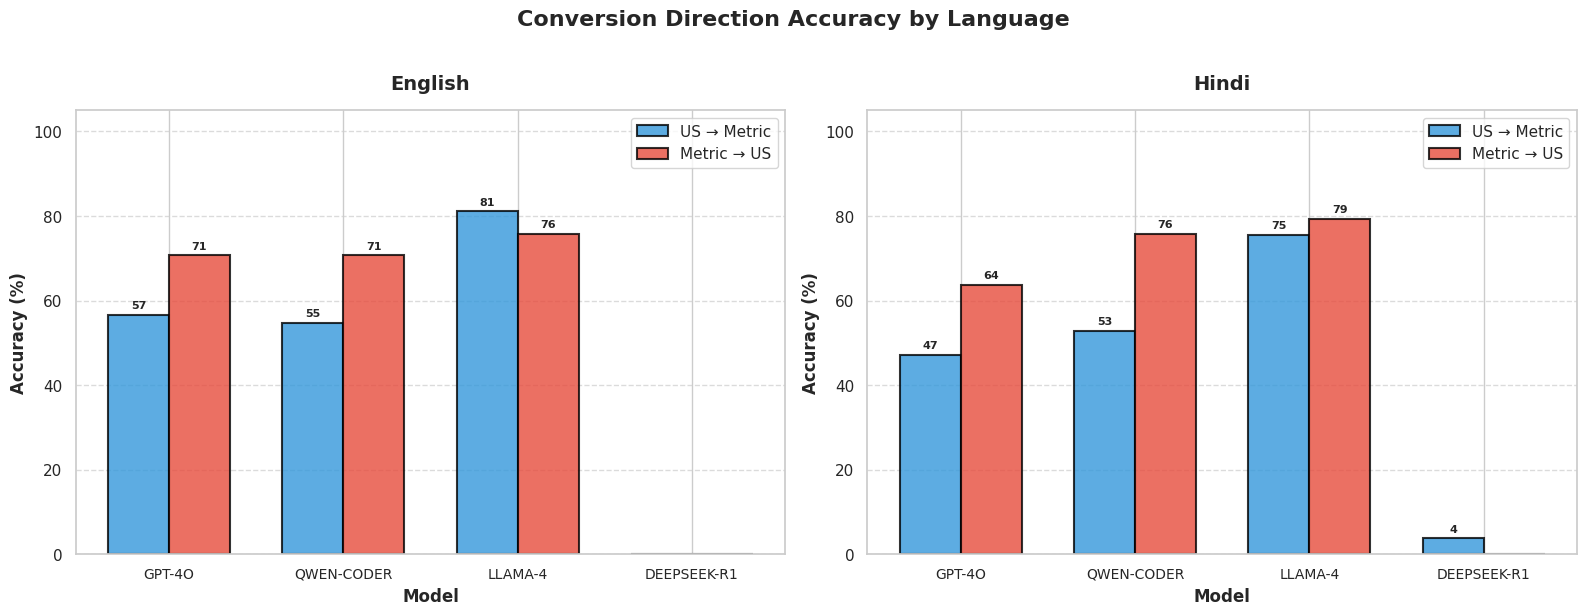

In [9]:

# Cell 4: Accuracy by conversion type and language
def plot_conversion_type_comparison(df, output_dir="language_conversion_results/plots"):
    """Compare US→Metric vs Metric→US accuracy."""
    
    # Calculate accuracy
    type_accuracy = df.groupby(['model', 'language', 'conversion_type'])['is_correct'].mean().reset_index()
    type_accuracy.columns = ['model', 'language', 'conversion_type', 'accuracy']
    type_accuracy['accuracy'] = type_accuracy['accuracy'] * 100
    
    models = df['model'].unique()
    
    # Create subplots for each language
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    languages = ['english', 'hindi']
    lang_labels = ['English', 'Hindi']
    colors = {'us_to_metric': '#3498db', 'metric_to_us': '#e74c3c'}
    
    for idx, (lang, lang_label) in enumerate(zip(languages, lang_labels)):
        ax = axes[idx]
        lang_data = type_accuracy[type_accuracy['language'] == lang]
        
        x = np.arange(len(models))
        width = 0.35
        
        us_to_metric = []
        metric_to_us = []
        
        for model in models:
            model_data = lang_data[lang_data['model'] == model]
            us_acc = model_data[model_data['conversion_type'] == 'us_to_metric']['accuracy'].values
            metric_acc = model_data[model_data['conversion_type'] == 'metric_to_us']['accuracy'].values
            
            us_to_metric.append(us_acc[0] if len(us_acc) > 0 else 0)
            metric_to_us.append(metric_acc[0] if len(metric_acc) > 0 else 0)
        
        bars1 = ax.bar(x - width/2, us_to_metric, width, 
                      label='US → Metric', color=colors['us_to_metric'],
                      edgecolor='black', linewidth=1.5, alpha=0.8)
        bars2 = ax.bar(x + width/2, metric_to_us, width,
                      label='Metric → US', color=colors['metric_to_us'],
                      edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Customize
        ax.set_xlabel('Model', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax.set_title(f'{lang_label}', fontsize=14, fontweight='bold', pad=15)
        ax.set_xticks(x)
        ax.set_xticklabels([m.upper() for m in models], fontsize=10)
        ax.set_ylim(0, 105)
        ax.legend(fontsize=11)
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                           f'{height:.0f}', ha='center', va='bottom', 
                           fontsize=8, fontweight='bold')
    
    plt.suptitle('Conversion Direction Accuracy by Language', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    # output_file = os.path.join(output_dir, 'conversion_type_comparison.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

type_fig = plot_conversion_type_comparison(df)
plt.show()

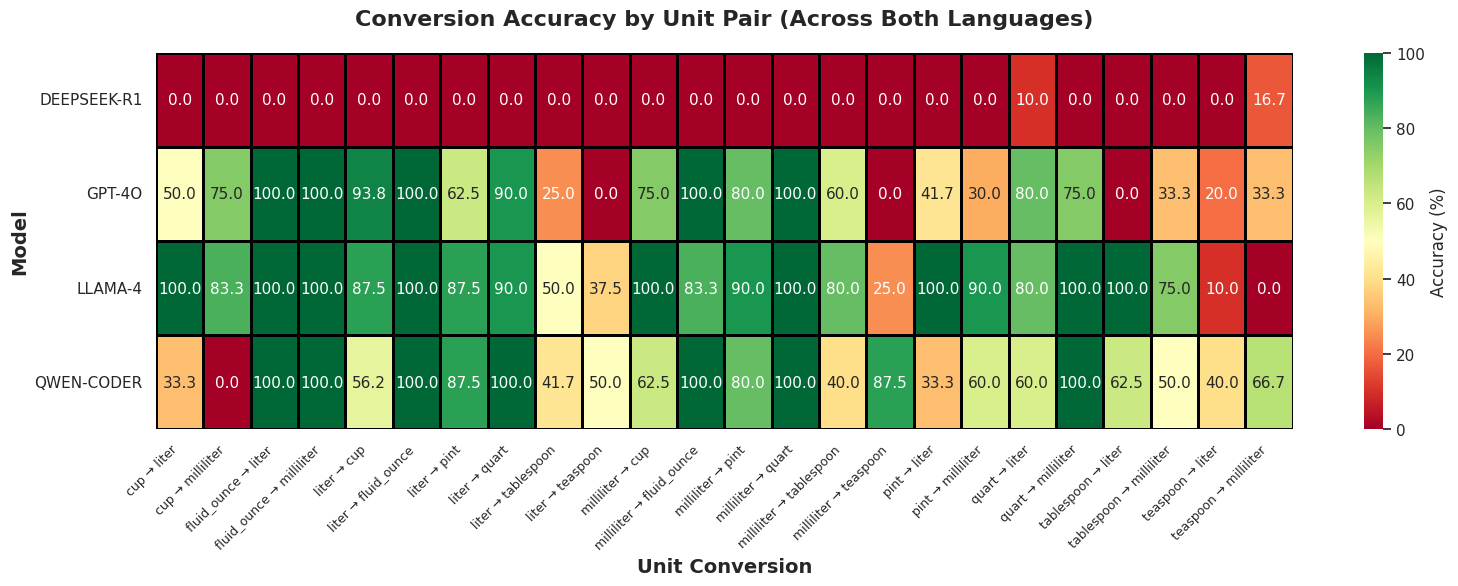

In [10]:

# Cell 5: Heatmap of accuracy by unit pairs
def plot_unit_pair_heatmap(df, output_dir="language_conversion_results/plots"):
    """Create heatmap showing accuracy for different unit conversions."""
    
    # Create from_unit -> to_unit labels
    df['unit_pair'] = df['from_unit'] + ' → ' + df['to_unit']
    
    # Calculate accuracy by model and unit pair
    unit_accuracy = df.groupby(['model', 'unit_pair'])['is_correct'].mean().reset_index()
    unit_accuracy.columns = ['model', 'unit_pair', 'accuracy']
    unit_accuracy['accuracy'] = unit_accuracy['accuracy'] * 100
    
    # Pivot for heatmap
    heatmap_data = unit_accuracy.pivot(index='model', columns='unit_pair', values='accuracy')
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                vmin=0, vmax=100, cbar_kws={'label': 'Accuracy (%)'},
                linewidths=1, linecolor='black', ax=ax)
    
    # Customize
    ax.set_xlabel('Unit Conversion', fontsize=14, fontweight='bold')
    ax.set_ylabel('Model', fontsize=14, fontweight='bold')
    ax.set_title('Conversion Accuracy by Unit Pair (Across Both Languages)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()], 
                       rotation=0, fontsize=11)
    ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], 
                       rotation=45, ha='right', fontsize=9)
    
    plt.tight_layout()
    
    # Save
    # output_file = os.path.join(output_dir, 'unit_pair_heatmap.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

unit_fig = plot_unit_pair_heatmap(df)
plt.show()

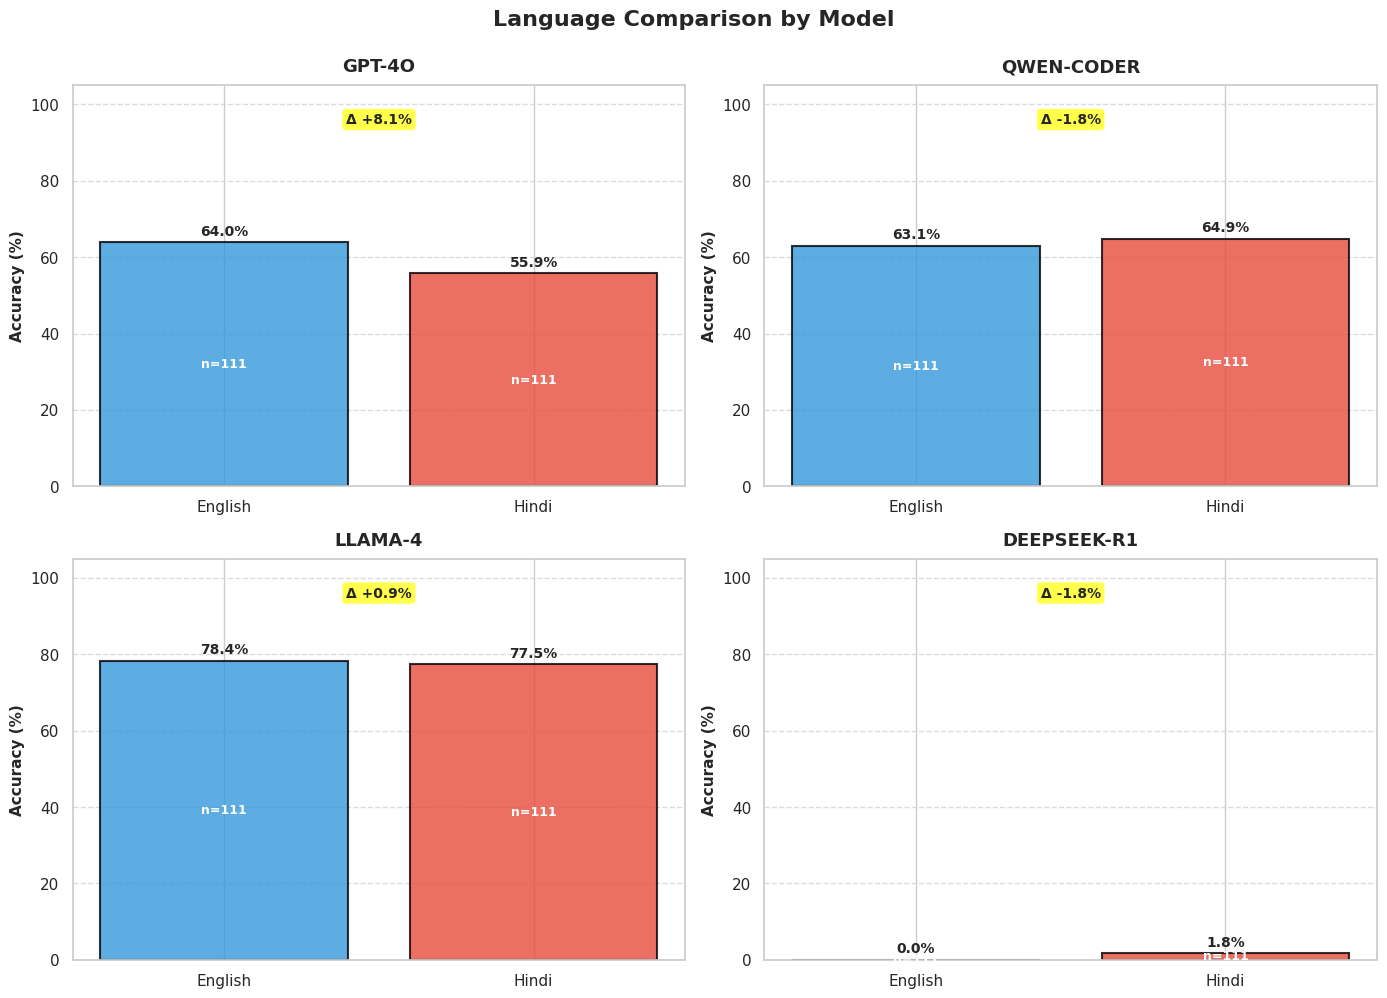

In [6]:

# Cell 6: Language bias by model (detailed)
def plot_language_bias_detailed(df, output_dir="language_conversion_results/plots"):
    """Create detailed language bias visualization."""
    
    models = df['model'].unique()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, model in enumerate(models):
        ax = axes[idx]
        model_data = df[df['model'] == model]
        
        # Calculate accuracy by language
        lang_stats = model_data.groupby('language')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
        lang_stats.columns = ['language', 'correct', 'total', 'accuracy']
        lang_stats['accuracy'] = lang_stats['accuracy'] * 100
        
        colors = {'english': '#3498db', 'hindi': '#e74c3c'}
        bar_colors = [colors[lang] for lang in lang_stats['language']]
        
        bars = ax.bar(range(len(lang_stats)), lang_stats['accuracy'], 
                     color=bar_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Customize
        ax.set_title(f'{model.upper()}', fontsize=13, fontweight='bold', pad=10)
        ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax.set_xticks(range(len(lang_stats)))
        ax.set_xticklabels(['English', 'Hindi'], fontsize=11)
        ax.set_ylim(0, 105)
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        
        # Add value labels
        for i, (bar, row) in enumerate(zip(bars, lang_stats.itertuples())):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                   f'n={int(row.total)}', ha='center', va='center', 
                   fontsize=9, color='white', fontweight='bold')
        
        # Add difference
        if len(lang_stats) == 2:
            diff = lang_stats.iloc[0]['accuracy'] - lang_stats.iloc[1]['accuracy']
            ax.text(0.5, 95, f'Δ {diff:+.1f}%', 
                   transform=ax.transData, ha='center', 
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    plt.suptitle('Language Comparison by Model', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save
    # output_file = os.path.join(output_dir, 'language_bias_detailed.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

bias_fig = plot_language_bias_detailed(df)
plt.show()

In [7]:

# Cell 7: Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

# Overall by model and language
print("\nAccuracy by Model and Language:")
lang_stats = df.groupby(['model', 'language'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
lang_stats.columns = ['Model', 'Language', 'Correct', 'Total', 'Accuracy']
lang_stats['Accuracy'] = lang_stats['Accuracy'] * 100
lang_stats = lang_stats.sort_values(['Model', 'Language'])
print(lang_stats.to_string(index=False))

# Language bias calculation
print("\n\nLanguage Bias (English - Hindi):")
bias_summary = []
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    eng_acc = model_data[model_data['language'] == 'english']['is_correct'].mean() * 100
    hin_acc = model_data[model_data['language'] == 'hindi']['is_correct'].mean() * 100
    diff = eng_acc - hin_acc
    
    bias_summary.append({
        'Model': model,
        'English Accuracy': eng_acc,
        'Hindi Accuracy': hin_acc,
        'Difference': diff,
        'Bias': 'English' if diff > 1 else 'Hindi' if diff < -1 else 'Neutral'
    })

bias_df = pd.DataFrame(bias_summary)
print(bias_df.to_string(index=False))

# Conversion type accuracy
print("\n\nAccuracy by Conversion Type:")
type_stats = df.groupby('conversion_type')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
type_stats.columns = ['Conversion Type', 'Correct', 'Total', 'Accuracy']
type_stats['Accuracy'] = type_stats['Accuracy'] * 100
print(type_stats.to_string(index=False))

print("="*80)



STATISTICAL SUMMARY

Accuracy by Model and Language:
      Model Language  Correct  Total  Accuracy
deepseek-r1  english        0    111  0.000000
deepseek-r1    hindi        2    111  1.801802
     gpt-4o  english       71    111 63.963964
     gpt-4o    hindi       62    111 55.855856
    llama-4  english       87    111 78.378378
    llama-4    hindi       86    111 77.477477
 qwen-coder  english       70    111 63.063063
 qwen-coder    hindi       72    111 64.864865


Language Bias (English - Hindi):
      Model  English Accuracy  Hindi Accuracy  Difference    Bias
     gpt-4o         63.963964       55.855856    8.108108 English
 qwen-coder         63.063063       64.864865   -1.801802   Hindi
    llama-4         78.378378       77.477477    0.900901 Neutral
deepseek-r1          0.000000        1.801802   -1.801802   Hindi


Accuracy by Conversion Type:
Conversion Type  Correct  Total  Accuracy
   metric_to_us      253    464 54.525862
   us_to_metric      197    424 46.462264
